In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import trange


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Set visualization style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams['font.size'] = 18

In [4]:
# Load data
data = pd.read_csv('https://fnd-jedha-project.s3.eu-west-3.amazonaws.com/0_WELFake_workbase.csv')
print(data.head(10))

   label                                            message
0      0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1      0  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
2      1  Bobby Jindal, raised Hindu, uses story of Chri...
3      0  SATAN 2: Russia unvelis an image of its terrif...
4      0  About Time! Christian Group Sues Amazon and SP...
5      0  DR BEN CARSON TARGETED BY THE IRS: “I never ha...
6      0  HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...
7      0  Sports Bar Owner Bans NFL Games…Will Show Only...
8      0  Latest Pipeline Leak Underscores Dangers Of Da...
9      0   GOP Senator Just Smacked Down The Most Puncha...


In [5]:
# Check label distribution
print(data['label'].value_counts())

label
1    34791
0    28330
Name: count, dtype: int64


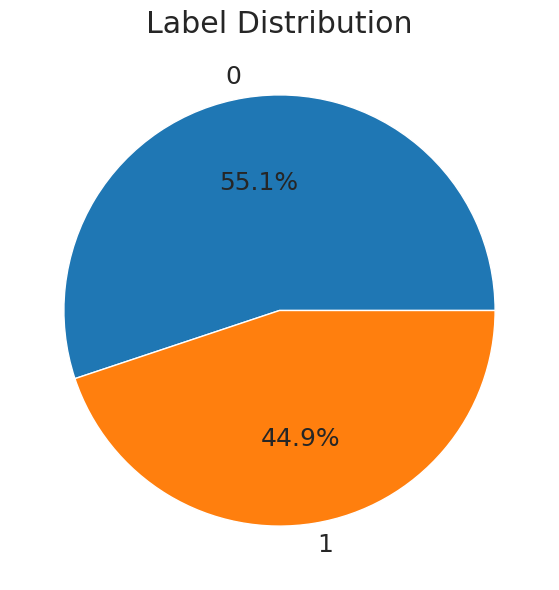

In [6]:
# Visualize label distribution
plt.pie(data['label'].value_counts(), labels=data['label'].unique().tolist(), autopct='%1.1f%%')
plt.title('Label Distribution')
plt.show()

In [7]:
# Feature engineering: Character count, word count, mean word length, mean sentence length
data['char_count'] = data['message'].apply(len)
data['word_count'] = data['message'].apply(lambda x: len(x.split()))
data['mean_word_length'] = data['message'].apply(lambda x: np.mean([len(word) for word in x.split()]))
data['mean_sent_length'] = data['message'].apply(lambda x: np.mean([len(sent) for sent in tokenize.sent_tokenize(x)]))

print(data.head())

   label                                            message  char_count  \
0      0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...        5182   
1      0  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...         356   
2      1  Bobby Jindal, raised Hindu, uses story of Chri...        8118   
3      0  SATAN 2: Russia unvelis an image of its terrif...        2014   
4      0  About Time! Christian Group Sues Amazon and SP...        1611   

   word_count  mean_word_length  mean_sent_length  
0         890          4.744944        109.021277  
1          53          5.660377        117.000000  
2        1338          5.045590        167.645833  
3         346          4.820809        200.500000  
4         258          5.205426        177.888889  


In [8]:
# Function to visualize features
def visualize_feature(col):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], x=data['label'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    melted_data = pd.melt(data, id_vars=['label'], value_vars=[col])
    sns.kdeplot(data=melted_data, x='value', hue='label')
    plt.legend(data['label'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.suptitle(f'Distribution of {col} by Label')
    plt.show()

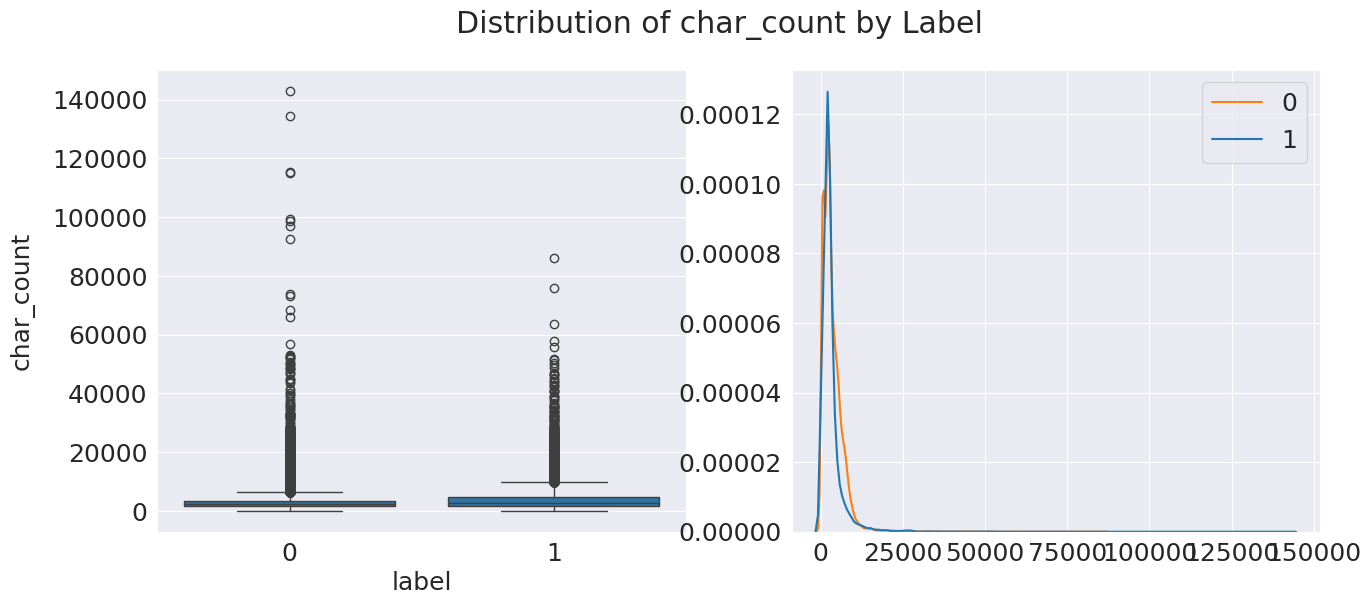

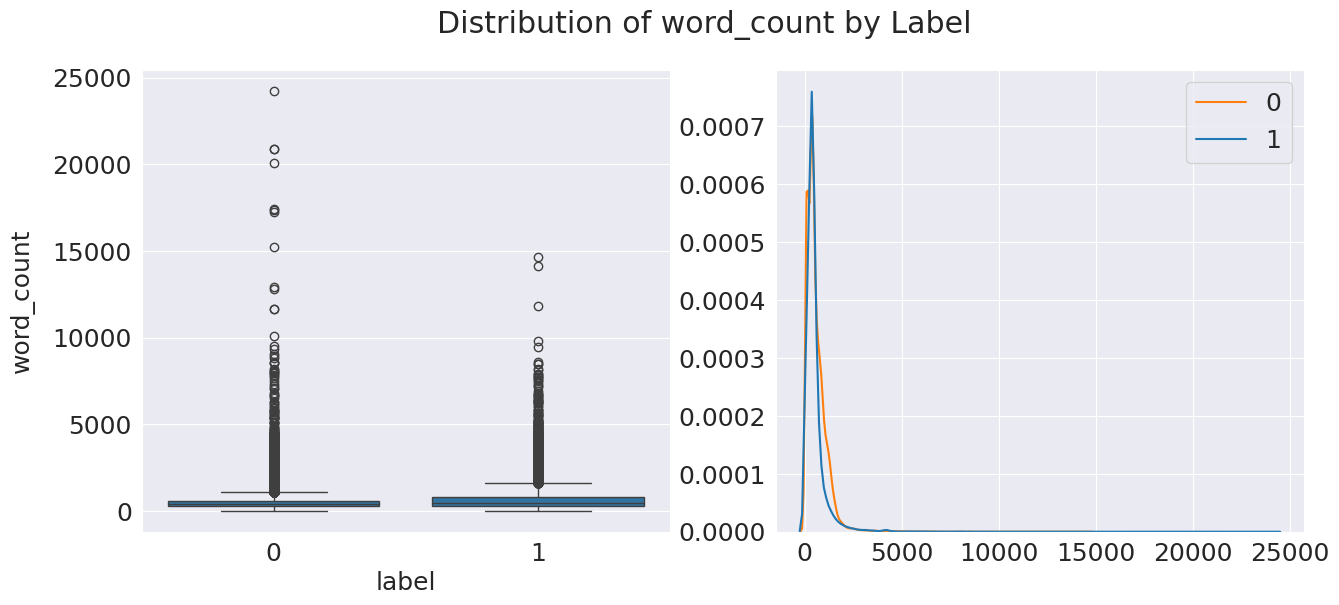

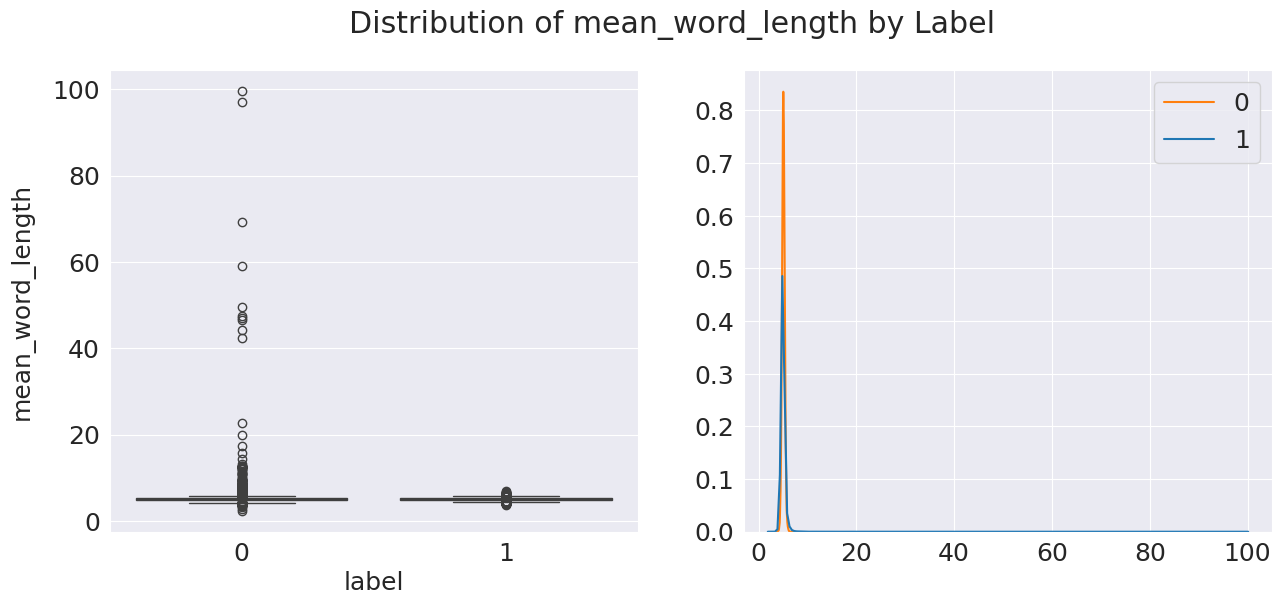

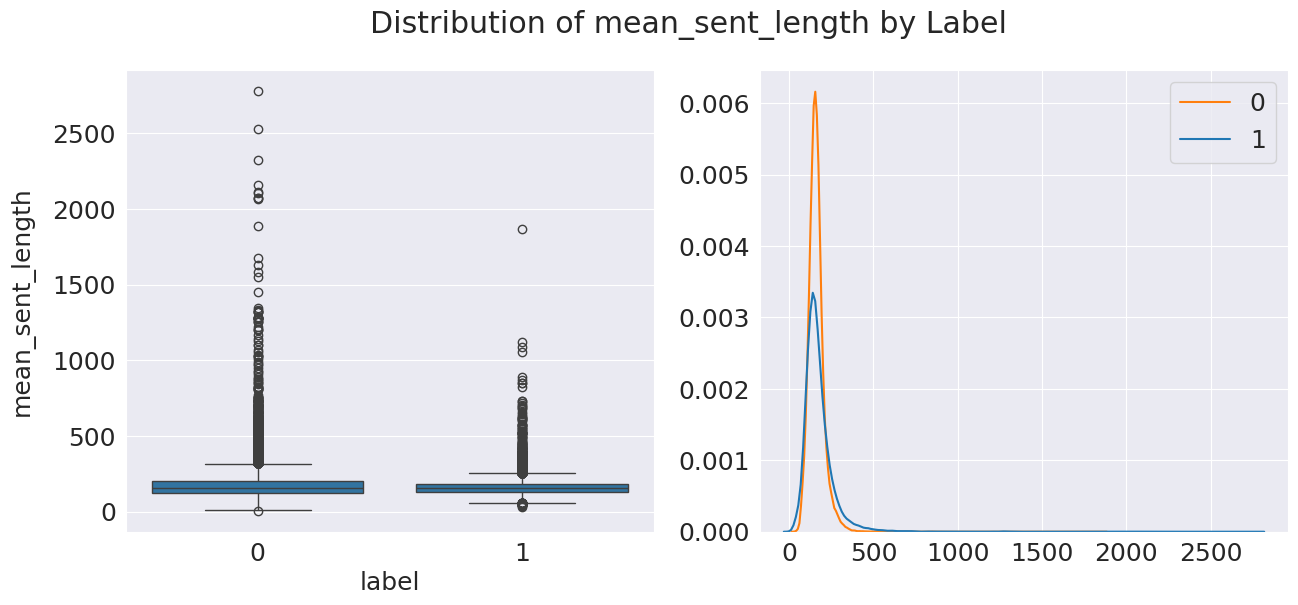

In [9]:
# Visualize all features
features = data.columns.tolist()[2:]
for feature in features:
    visualize_feature(feature)

In [10]:
# Drop engineered features for text cleaning
df = data.drop(features, axis=1)
print(df.head())

   label                                            message
0      0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1      0  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
2      1  Bobby Jindal, raised Hindu, uses story of Chri...
3      0  SATAN 2: Russia unvelis an image of its terrif...
4      0  About Time! Christian Group Sues Amazon and SP...


In [11]:
# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters (keep alphanumeric and hyphens)
    text = re.sub('[^a-zA-Z0-9-]+', ' ', text)

    # Remove standalone dashes
    text = re.sub(r'\b-\b', '', text)

    # Remove stopwords and unwanted words
    stop_words = set(stopwords.words('english'))
    unwanted_words = {'would', 'one', 'new', 'u', '-', 'could', 'like', 'also', 'mr', 'united', 'state', 'states', 'said'}
    text = " ".join([word for word in text.split() if word not in stop_words and word not in unwanted_words])

    return text

In [12]:
# Apply cleaning to the 'message' column
df['message'] = df['message'].apply(clean_text)
print(df.head())

   label                                            message
0      0  law enforcement high alert following threats c...
1      0  unbelievable obama attorney general says charl...
2      1  bobby jindal raised hindu uses story christian...
3      0  satan 2 russia unvelis image terrifying supern...
4      0  time christian group sues amazon splc designat...


In [13]:
# Create a corpus of words
def create_corpus(text):
    return text.split()

df['message_lists'] = df['message'].apply(create_corpus)
print(df.head())

   label                                            message  \
0      0  law enforcement high alert following threats c...   
1      0  unbelievable obama attorney general says charl...   
2      1  bobby jindal raised hindu uses story christian...   
3      0  satan 2 russia unvelis image terrifying supern...   
4      0  time christian group sues amazon splc designat...   

                                       message_lists  
0  [law, enforcement, high, alert, following, thr...  
1  [unbelievable, obama, attorney, general, says,...  
2  [bobby, jindal, raised, hindu, uses, story, ch...  
3  [satan, 2, russia, unvelis, image, terrifying,...  
4  [time, christian, group, sues, amazon, splc, d...  


In [14]:
# Flatten the corpus
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['message_lists'][i]

print(f"Total words in corpus: {len(corpus)}")

 26%|██████████████████████████▎                                                                            | 16159/63121 [00:00<00:00, 161573.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 63121/63121 [00:00<00:00, 169550.04it/s]

Total words in corpus: 19393226


In [15]:
# Most common words
most_common = Counter(corpus).most_common(10)
words, freq = zip(*most_common)

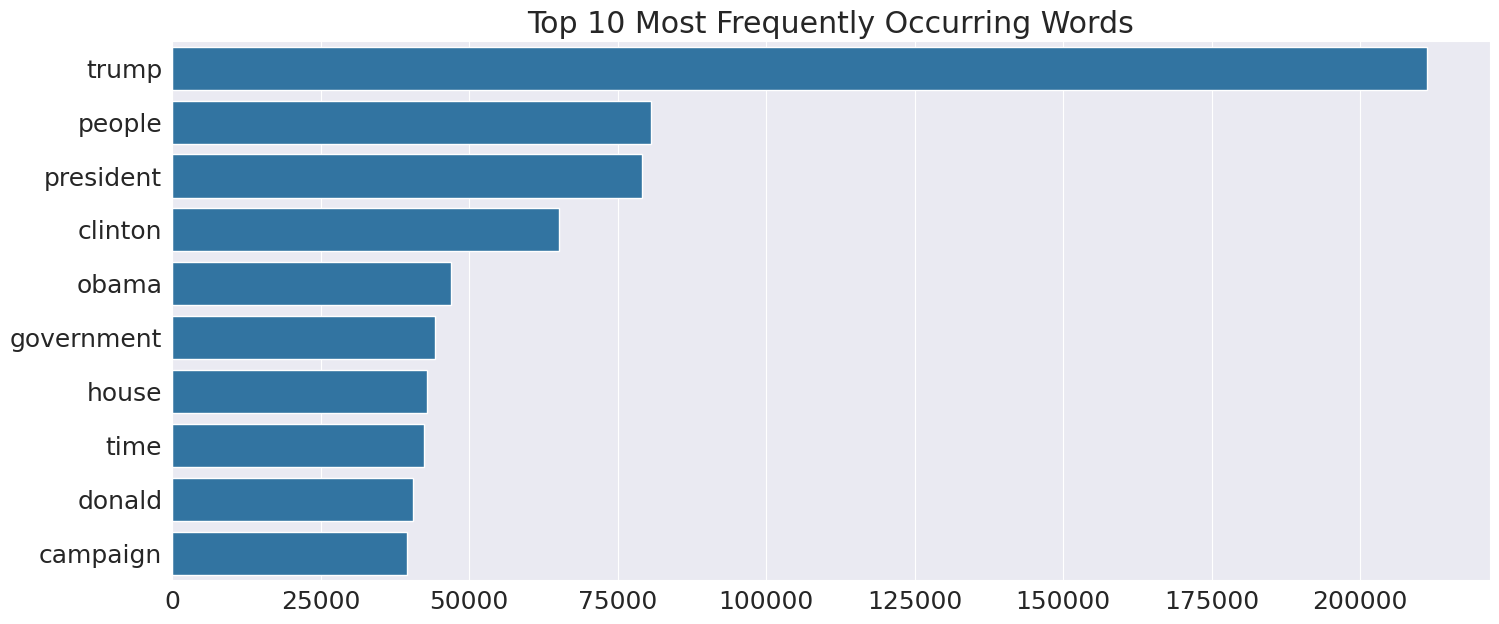

In [16]:
# Plot top 10 most frequent words
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 Most Frequently Occurring Words')
plt.show()

In [17]:
# Most frequent bigrams
cv = CountVectorizer(ngram_range=(2, 2),min_df=10, max_features=10000)
bigrams = cv.fit_transform(df['message'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
ngram_freq.columns = ["frequency", "ngram"]

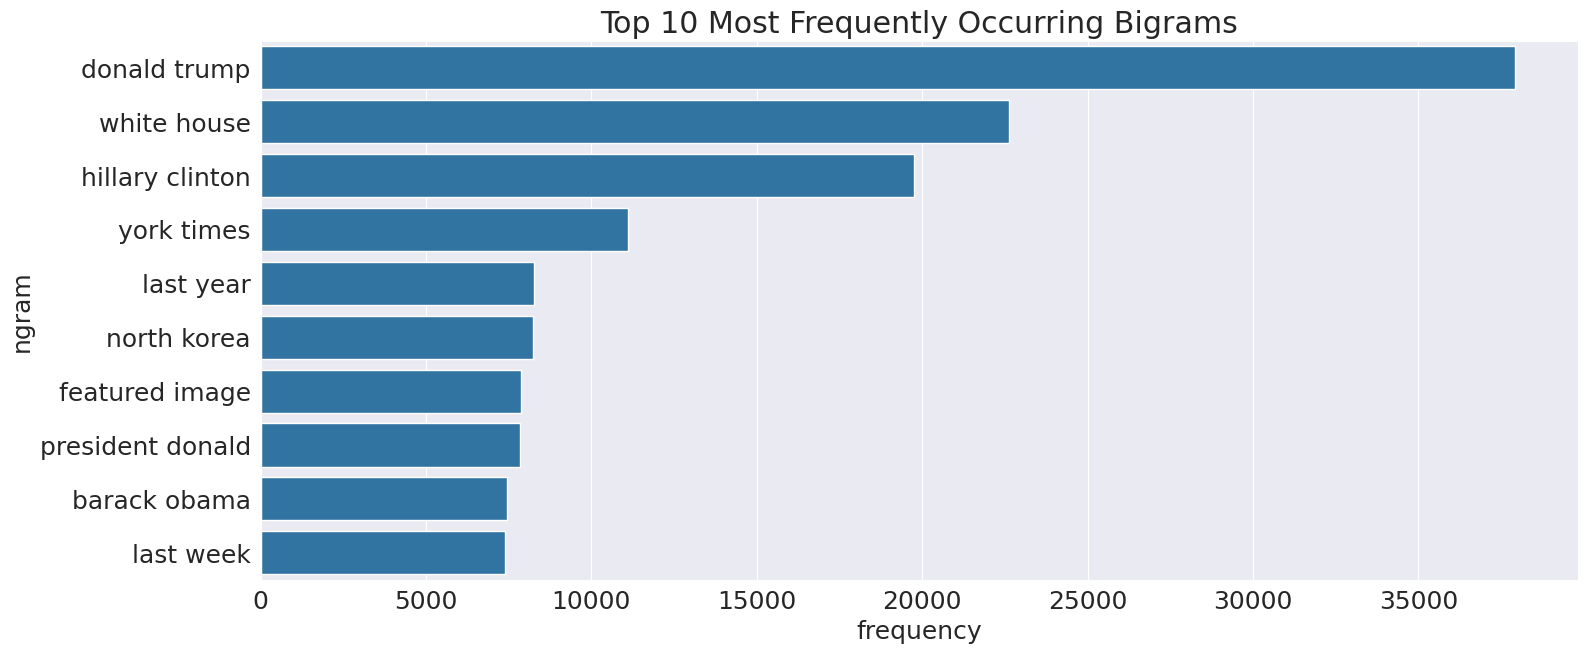

In [18]:
# Plot top 10 bigrams
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occurring Bigrams')
plt.show()

In [19]:
# Most frequent trigrams
cv1 = CountVectorizer(ngram_range=(3, 3))
trigrams = cv1.fit_transform(df['message'])
count_values = trigrams.sum(axis=0).A1
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse=True))
ngram_freq.columns = ["frequency", "ngram"]

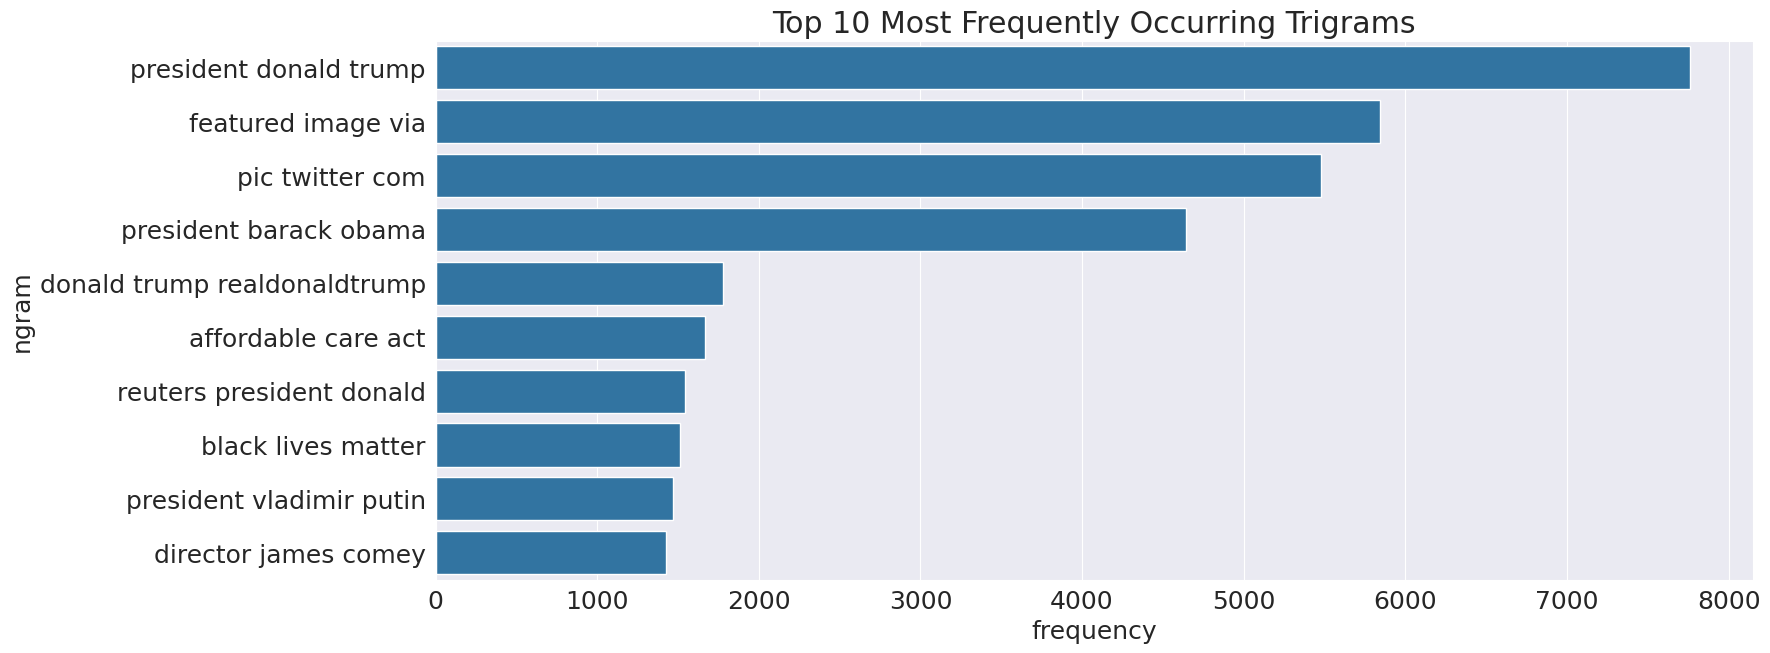

In [20]:
# Plot top 10 trigrams
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occurring Trigrams')
plt.show()

In [21]:
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
# Function to generate word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

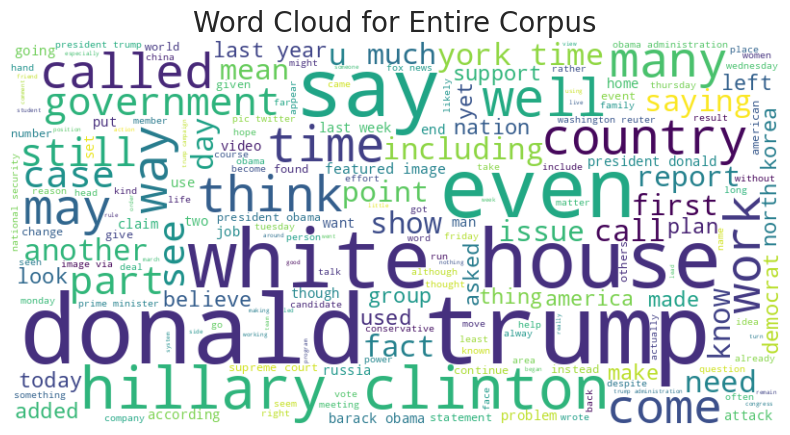

In [23]:
# Generate word cloud for the entire corpus
corpus_text = ' '.join(corpus)
generate_wordcloud(corpus_text, 'Word Cloud for Entire Corpus')

In [24]:
# Topic Modeling using LDA
# Step 1: Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['message'])

In [25]:
# Step 2: Apply LDA for topic modeling
num_topics = 6  # Number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=6, random_state=42)

In [26]:
# Step 3: Display top 10 words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# Get feature names (words) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Display top 10 words for each topic
display_topics(lda, tfidf_feature_names, num_top_words=10)

Topic 1:
police officers milo black officer ru video pravda protesters cops

Topic 2:
trump clinton president obama hillary republican house donald campaign people

Topic 3:
nfl kaepernick anthem players quake galacticconnection nasralla quarterback pinera earthquake

Topic 4:
korea north china korean taiwan south beijing pyongyang xi japan

Topic 5:
syria iran reuters minister russia military government islamic eu syrian

Topic 6:
trump percent people clinton tax year million world years president



In [27]:
# Step 4: Generate word clouds for each topic
def generate_topic_wordclouds(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
        generate_wordcloud(top_words, f'Word Cloud for Topic {topic_idx + 1}')

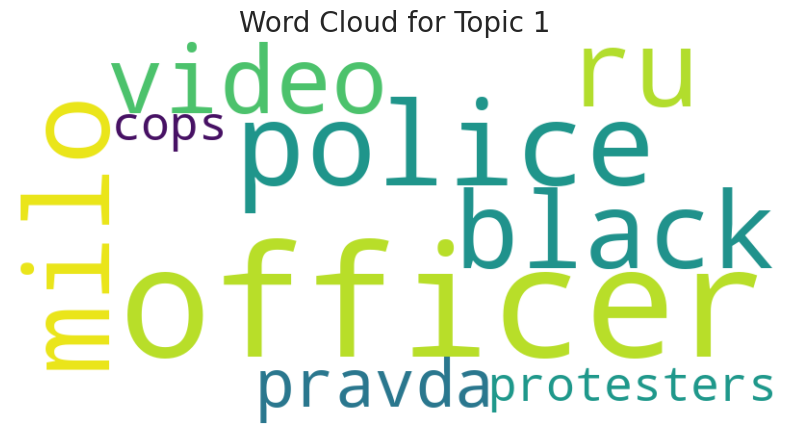

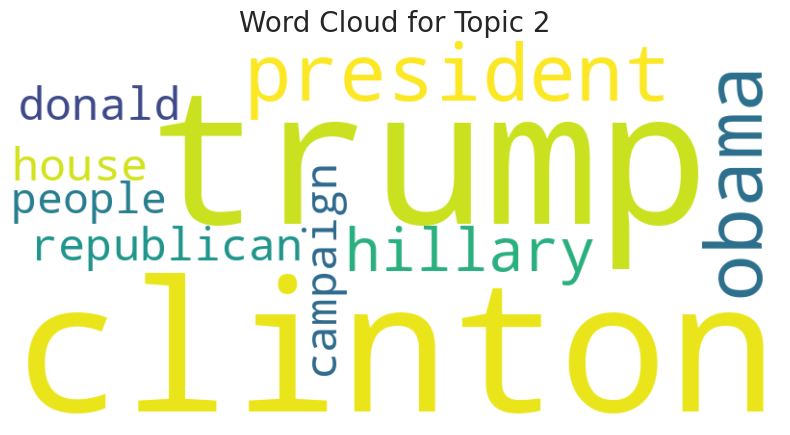

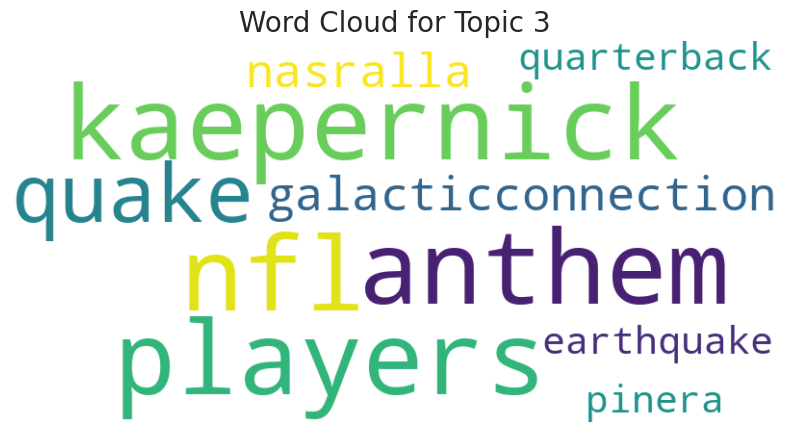

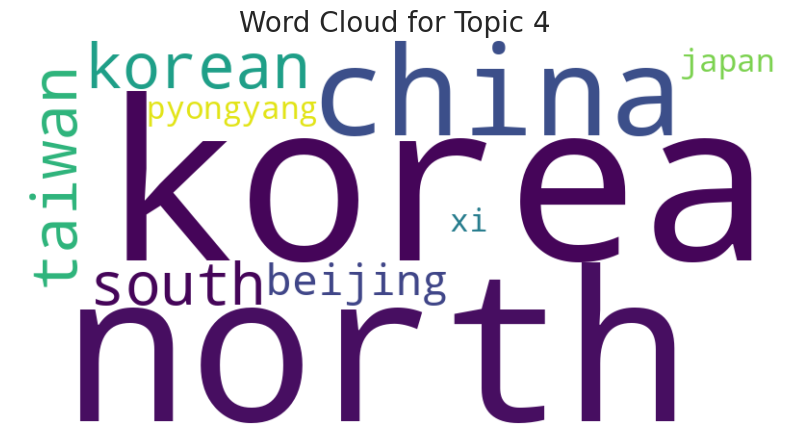

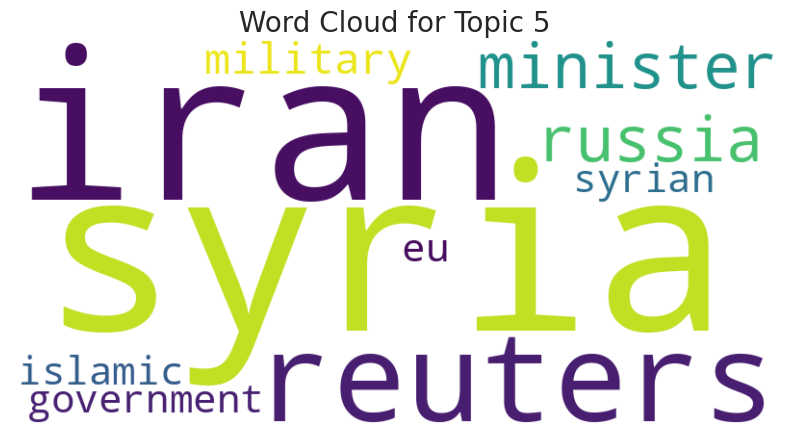

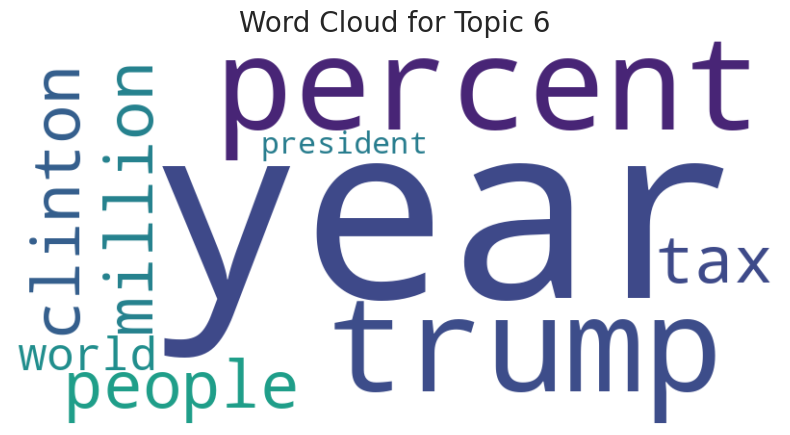

In [28]:
# Generate word clouds for each topic
generate_topic_wordclouds(lda, tfidf_feature_names, num_top_words=10)